# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [1]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
#import seaborn as sb


In [3]:
pwd

'/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101'

In [4]:
workdir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/'
datadir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/data/'
outdir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/data/butane.pdb
/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/data/butane.gaff2.xml


In [5]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295271861905623 kJ/mol


In [6]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,37.609114375957205,249.28142753402236
2000,32.59780098716982,261.7346036822084


In [7]:
os.path.join(workdir, "butane_sim.dcd")

'/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/butane_sim.dcd'

In [8]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,40.60042383930329,325.74100326455505,0
500000,999.9999999901769,45.64469493629455,340.3031483249359,2.11e+04
750000,1499.9999999783536,48.3789284764084,204.6016543493141,2.11e+04
1000000,1999.9999999665301,45.20110289454924,307.7737322727632,2.1e+04
1250000,2499.9999999547067,37.89612081223566,329.800408624267,2.09e+04
1500000,2999.9999999428833,39.399331864208804,308.39689521883537,2.05e+04
1750000,3499.99999993106,34.74287111366591,418.68068081810236,1.96e+04
2000000,3999.9999999192364,34.64017429086283,257.95671505558,1.93e+04
2250000,4499.9999999992715,57.25403045656274,332.64674258691286,1.9e+04
2500000,5000.000000101135,67.706668406375,360.13916701962535,1.92e+04
2750000,5500.000000202998,39.94828559655407,243.10790349773742,1.93e+04
3000000,6000.000000304862,27.378595626278702,292.6427743361376,1.94e+04
3250000,6500.000000406725,40.730103261492665,23

In [9]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.dcd"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x15195af10>

In [10]:
atoms, bonds = traj.topology.to_dataframe() #topology file as a dataframe
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [11]:
top=traj.topology
C_sel=top.select("type C")
print(C_sel)
top.atom(5)

H_sel=top.select("type H")
for atom in H_sel:
    print(atom, top.atom(atom))

[ 0  4  7 10]
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [12]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x151a1ee90>

In [13]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


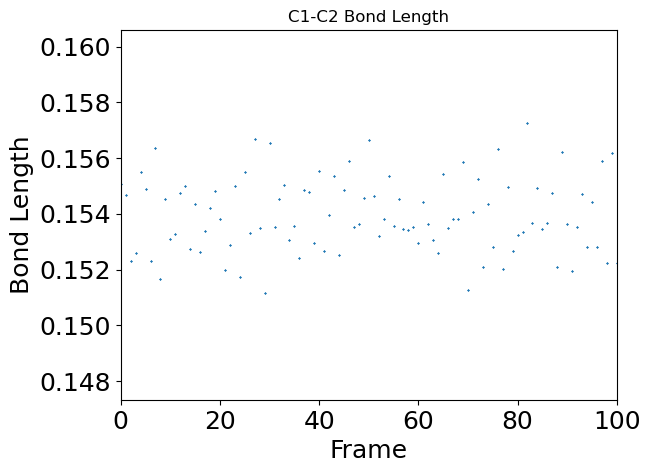

In [14]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=1) #small lw to see things
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=1) #better for noisy time series so you can see things and its not a blob 
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlim([0,100])
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

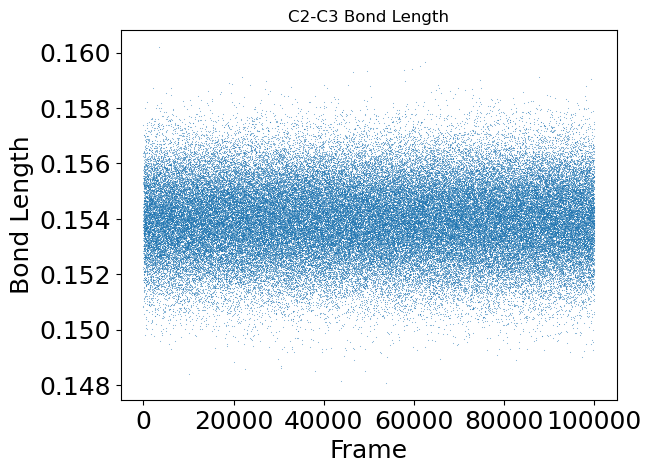

In [15]:
bond_indices = [4, 7] 
#indices based on data frame, but C1-C4 for the actual molecule drawing
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

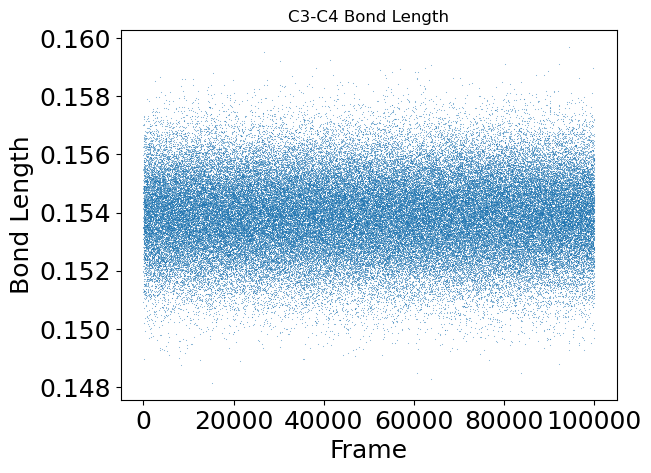

In [16]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

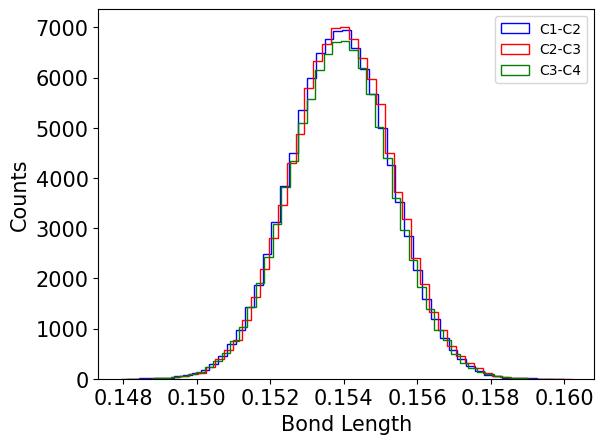

In [17]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

#terminal bonds have indistinguishablee distribution! for C1-C2 and C3-C4 bonds 
#but the C2-C3 bond is different

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

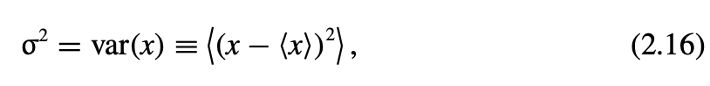

In [687]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [18]:
###SOLUTION###
def variance(data):
    ave = np.average(data)
    var = np.average((data-ave)**2)
    std = var**0.5
    return(var, std) 

C1C2var, C1C2std = variance(C1C2bondlength)
print("C1-C2 variance:", C1C2var, "C1-C2 standard deviation:", C1C2std)

C2C3var, C2C3std = variance(C2C3bondlength)
print("C2-C3 variance:", C2C3var, "C2-C3 standard deviation:", C2C3std)

C3C4var, C3C4std = variance(C3C4bondlength)
print("C3-C4 variance:", C3C4var, "C3-C4 standard deviation:", C3C4std)

C1-C2 variance: 1.8841405e-06 C1-C2 standard deviation: 0.0013726399703029094
C2-C3 variance: 1.883516e-06 C2-C3 standard deviation: 0.001372412476726136
C3-C4 variance: 1.8726915e-06 C3-C4 standard deviation: 0.0013684632042527043


In [19]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

#bonds similar!  1.539 angstroms 

C1-C2 average: 0.15390173 variance: 1.8841405e-06 std-dev: 0.00137264
C2-C3 average: 0.15395492 variance: 1.883516e-06 std-dev: 0.0013724124
C3-C4 average: 0.15390731 variance: 1.8726915e-06 std-dev: 0.0013684632


In [20]:
np.shape(C1C2bondlength[:,0])
#switch to a 1D array 

(100000,)

***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


Line Parameters: LinregressResult(slope=-0.10011982280165148, intercept=0.16936353668965895, rvalue=-0.10013641880277813, pvalue=3.6827308866414336e-221, stderr=0.003145893154573596, intercept_stderr=0.00048417764272462696)


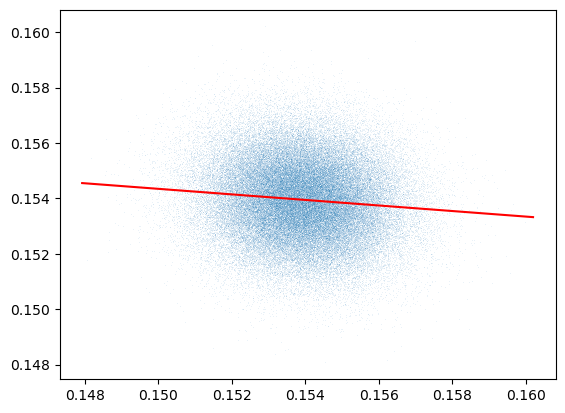

r2: -0.10013641880277813
Line Parameters: LinregressResult(slope=0.013895324143299812, intercept=0.15176879957382225, rvalue=0.01393773464844605, pvalue=1.0449453003064459e-05, stderr=0.003152380598849233, intercept_stderr=0.0004851761113064727)


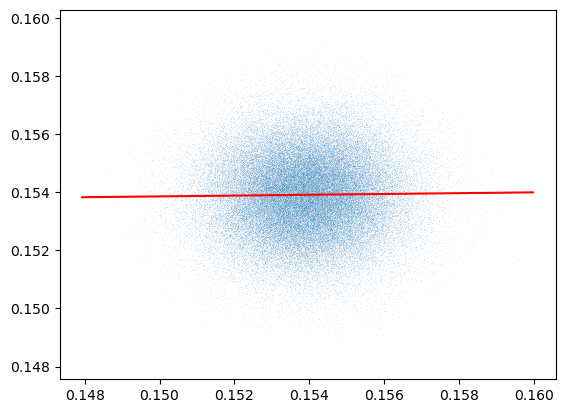

r2: 0.013937734648446047


In [21]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit = scipy.stats.linregress(C1C2bondlength[:,0], C2C3bondlength[:,0])
 #fit to line, x value is C1-C2 and y is C2-C3 
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=scipy.stats.linregress(C1C2bondlength[:,0],C3C4bondlength[:,0])
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Figure size 640x480 with 0 Axes>

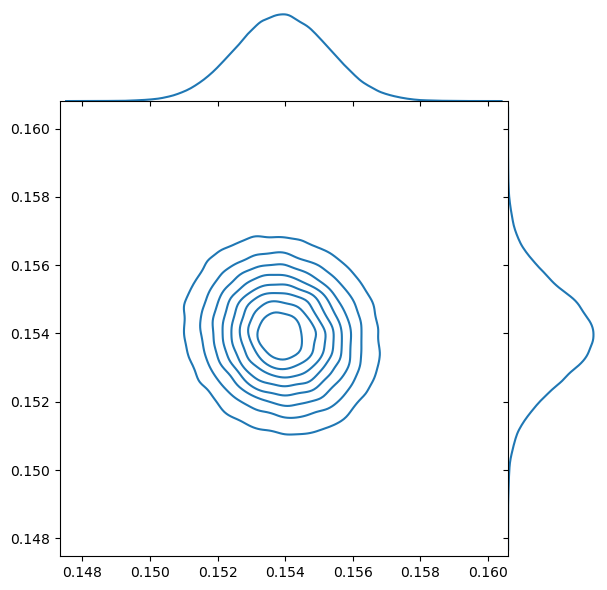

In [22]:
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0], y=C2C3bondlength[:,0], kind='kde', space=0,thresh=0)

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

ANSWER: The plot showing the C1C2/C2C3 bond correlation shows a better correlation (looking at r^2 absolute values) given that the bonds are right next to each other). This suggests that they are in a more chemically similar environment and show a slight correlation with bond length. the C1C2/C3C4 bond correlation is roughly 0 (r^2 value = 0. 004), which makes sense given that these two bonds are further apart/in different environments.

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

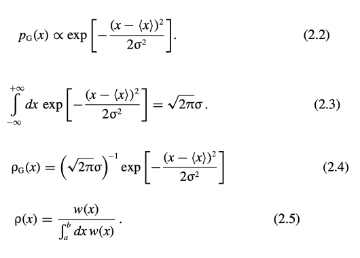
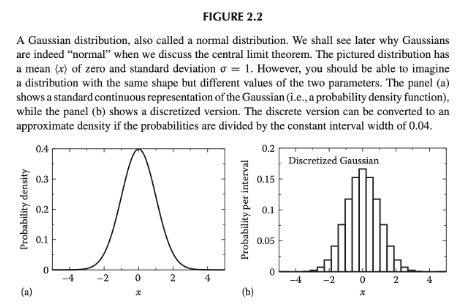

Need the center value of each bin rather than the boundaries 

[    0     3    18    68   296  1022  2922  6419 11436 16443 18609 17013
 12773  7586  3502  1345   410   105    24     6] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
[0.14732501 0.147975   0.148625   0.149275   0.149925   0.15057501
 0.151225   0.15187499 0.15252501 0.153175   0.153825   0.154475
 0.15512499 0.15577501 0.156425   0.15707499 0.157725   0.158375
 0.159025   0.159675  ]
initial guesses: [0.15998586, 0.15390174, 0.00137264]
a: 0.1868582797569248, x0: 0.15389971819660156, sigma: 0.0013891828159281936


Text(0, 0.5, 'Probability')

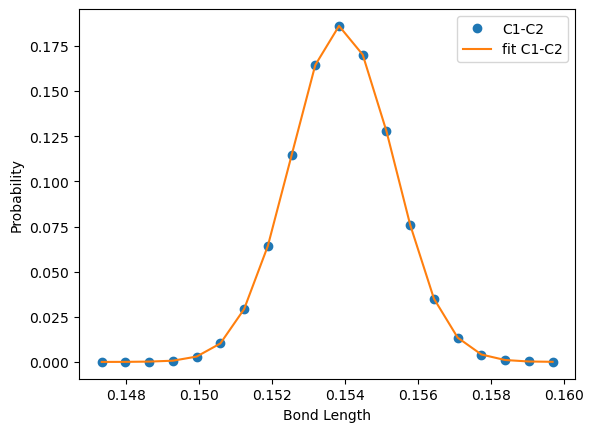

In [23]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

counts, edges = np.histogram(C1C2bondlength, bins=20, range=[0.147, 0.160])
print(counts, edges)
#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:
centers = edges[:-1] + np.diff(edges)/2 #take start point and add 1/2 the difference to get the midpoint of bins
print(centers)

density = counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####
###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x, a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*(sigma**2))))
    #x0 is the average, sigma is stdev

#### Now we define a function to fit the gaussian with curve fit
def fit_gauss(x, y, arr): 
    a = max(arr)
    x0 = mean(arr)
    sigma = np.std(arr)
    p0 = [a, x0, sigma]
    print(f'initial guesses: {p0}')
    parameters, covar = curve_fit(gauss, x, y, p0=p0)
    fit_a, fit_x0, fit_sigma = parameters[0], parameters[1], parameters[2]
    print(f'a: {fit_a}, x0: {fit_x0}, sigma: {fit_sigma}')
    fit_y = gauss(x, fit_a, fit_x0, fit_sigma)
    return fit_y, [fit_a, fit_x0, fit_sigma]

new_arr = C1C2bondlength.squeeze()
C1C2_fit, C1C2_fit_params=fit_gauss(centers, density, new_arr)

plt.plot(centers, density, 'o', label='C1-C2')
plt.plot(centers, density, '-', label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

initial guesses: [0.15998586, 0.15390174, 0.00137264]
a: 0.1868582797569248, x0: 0.15389971819660156, sigma: 0.0013891828159281936
initial guesses: [0.16020352, 0.15395491, 0.0013724124]
a: 0.18687086641629153, x0: 0.15394966801056673, sigma: 0.0013888079886038422
initial guesses: [0.15969904, 0.15390731, 0.0013684632]
a: 0.18767452145188304, x0: 0.15391050700500333, sigma: 0.001381511627359052


Text(0, 0.5, 'Probability')

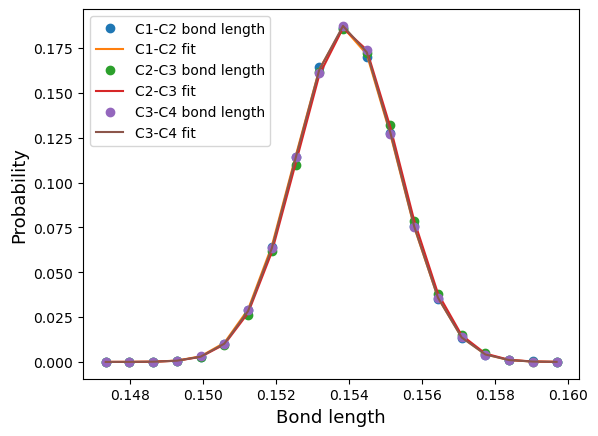

In [24]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
def histogram_bincenters(a,bins,x0, xmax):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2 #get midpoint of bins 
    density = counts/np.sum(counts)
    return density, centers
    
# Use this func to iterate over all CC bonds, plot densities and the fits
#make the above cell iterable 

C1C2_density,centers = histogram_bincenters(C1C2bondlength, 20, 0.147, 0.160) 
#print("C1C2_density:", C1C2_density, "centers:", centers)
C1C2_fit, C1C2_fit_params = fit_gauss(centers, C1C2_density, C1C2bondlength.squeeze()) 

C2C3_density,centers = histogram_bincenters(C2C3bondlength, 20, 0.147, 0.160) 
C2C3_fit, C2C3_fit_params = fit_gauss(centers, C2C3_density, C2C3bondlength.squeeze()) 

C3C4_density,centers = histogram_bincenters(C3C4bondlength, 20, 0.147, 0.160) 
C3C4_fit, C3C4_fit_params = fit_gauss(centers, C3C4_density, C3C4bondlength.squeeze()) 

#plotting curves/gaussian fit

plt.plot(centers,C1C2_density, 'o',label='C1-C2 bond length')
plt.plot(centers,C1C2_fit, '-',label='C1-C2 fit')

plt.plot(centers,C2C3_density, 'o',label='C2-C3 bond length')
plt.plot(centers,C2C3_fit, '-',label='C2-C3 fit')

plt.plot(centers,C3C4_density, 'o',label='C3-C4 bond length')
plt.plot(centers,C3C4_fit, '-',label='C3-C4 fit')

plt.legend()
plt.xlabel("Bond length", size="13")
plt.ylabel("Probability", size="13")


**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

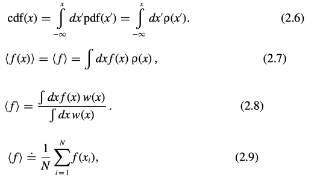

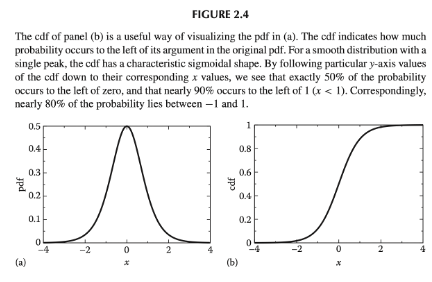

Bond length at half of the frames 0.153825
Bond length at half of the frames 0.153825
Bond length at half of the frames 0.153825
test (array([], dtype=int64),)


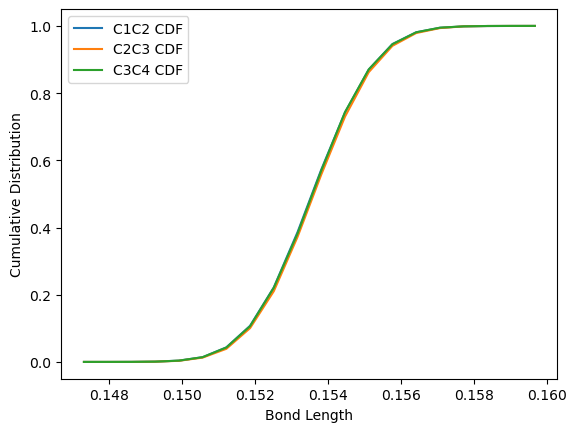

In [35]:
###WEEK 1 HOMEWORK#### 

#cumulative density function: integrate over the gaussian, what bond length do you have 1/2 the frames of distribution 
#np.cumsum could be helpful, try that function 
#show what fraction contained up until any given value 

#np.cumsum uses an array to find sum
#numpy.cumsum(a, axis=None, dtype=None, out=None)

####HOMEWORK SOLUTION####

#make empty array for eachbond length
#print(C1C2_density)
#want to convert the distribution into a CDF 
#already have array of densities from previous problem 

def plot_CDF(centers, density):
    CDF = np.cumsum(density)
    plt.plot(centers, CDF, '-') 
    plt.xlabel("Bond Length")
    plt.ylabel("Cumulative Distribution")

    half = np.argmax(CDF >= 0.5)
    half_bond_length = centers[half]
    print("Bond length at half of the frames", half_bond_length)

plot_CDF(centers, C1C2_density)
plot_CDF(centers, C2C3_density)
plot_CDF(centers, C3C4_density)

plt.legend(["C1C2 CDF", "C2C3 CDF", "C3C4 CDF"])

#where is it half the frames? 


print("test", half)
#showing probability that bond length is at or below that value, makes sense its a sigmoidal curve 



**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle ***
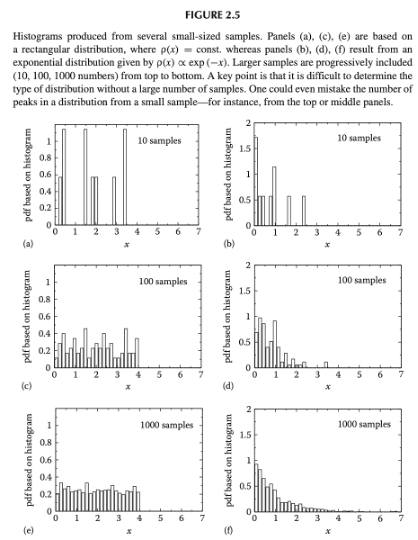

initial guesses: [0.15998586, 0.15390174, 0.00137264]
a: 0.20302922099101092, x0: 0.15355042842981825, sigma: 0.0012986852837944744
initial guesses: [0.16020352, 0.15395491, 0.0013724124]
a: 0.20432031350247143, x0: 0.15310935811762627, sigma: 0.0013796165317314076
initial guesses: [0.15969904, 0.15390731, 0.0013684632]
a: 0.1295348022596185, x0: 0.153922477292236, sigma: 0.002051098081520304


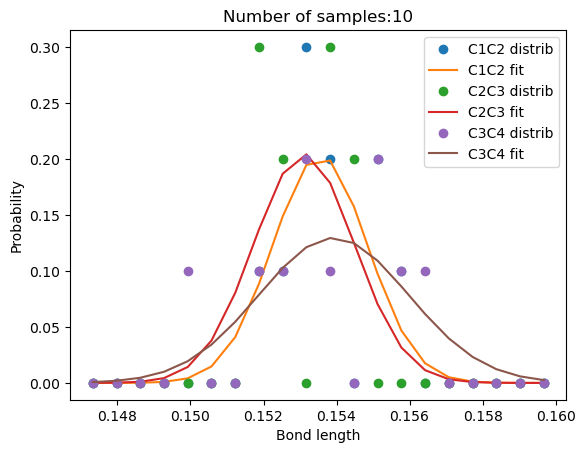

initial guesses: [0.15998586, 0.15390174, 0.00137264]
a: 0.19778376657298072, x0: 0.1539692424647384, sigma: 0.001326140503820129
initial guesses: [0.16020352, 0.15395491, 0.0013724124]
a: 0.17211229567770173, x0: 0.15407396097110387, sigma: 0.0015393314792516532
initial guesses: [0.15969904, 0.15390731, 0.0013684632]
a: 0.1847427631537322, x0: 0.15399254238446072, sigma: 0.0014202766937810609


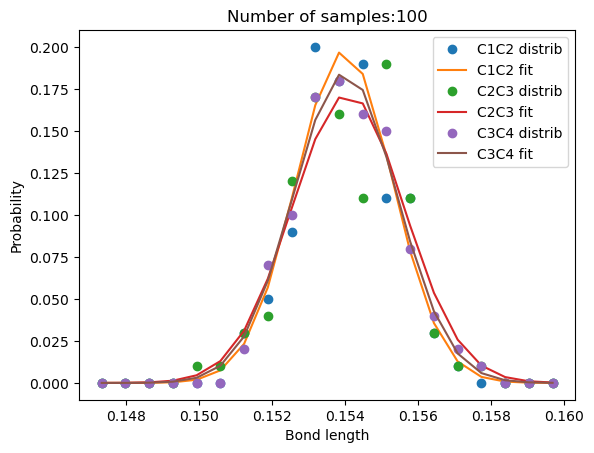

initial guesses: [0.15998586, 0.15390174, 0.00137264]
a: 0.19552809957140108, x0: 0.15398201757484004, sigma: 0.0013226584122809813
initial guesses: [0.16020352, 0.15395491, 0.0013724124]
a: 0.18307598876480666, x0: 0.15405943643220094, sigma: 0.00141432093957202
initial guesses: [0.15969904, 0.15390731, 0.0013684632]
a: 0.19714838218499667, x0: 0.1539213460223012, sigma: 0.0013107772224601666


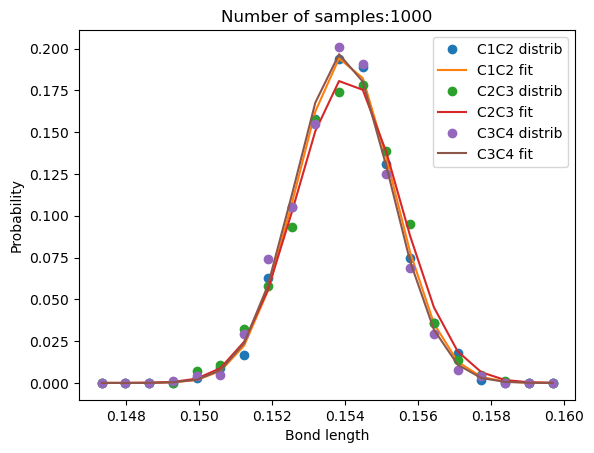

initial guesses: [0.15998586, 0.15390174, 0.00137264]
a: 0.1857813947968378, x0: 0.15391139298871323, sigma: 0.0013934552211025486
initial guesses: [0.16020352, 0.15395491, 0.0013724124]
a: 0.1905753761956466, x0: 0.15397825784245778, sigma: 0.0013563336253312867
initial guesses: [0.15969904, 0.15390731, 0.0013684632]
a: 0.1902394041194119, x0: 0.153899998775301, sigma: 0.0013649122966429821


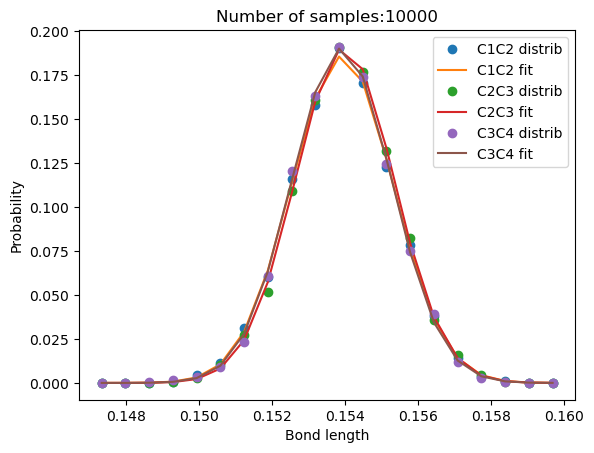

In [36]:
#ADD CODE FOR FITTING GAUSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE
# how many samples do you have to take to know what kind of fit you have? 
#This function might be helpful, generates random numbers between 0 and 10000 with 10000 values

#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?



#PART A: BOND ANGLE
rands=np.random.randint(10000, size=(10000)) 

samples = [10, 100, 1000, 10000]

for i in samples:
    rands = np.random.randint(10000, size=(i))
    C1C2rand_bond = C1C2bondlength[rands]
    C2C3rand_bond = C2C3bondlength[rands]
    C3C4rand_bond = C3C4bondlength[rands]

    C1C2rand_density, centers = histogram_bincenters(C1C2rand_bond, 20, 0.147, 0.160)
    C1C2rand_fit, C1C2rand_fit_params = fit_gauss(centers, C1C2rand_density, C1C2bondlength.squeeze())

    C2C3rand_density, centers = histogram_bincenters(C2C3rand_bond, 20, 0.147, 0.160)
    C2C3rand_fit, C2C3rand_fit_params = fit_gauss(centers, C2C3rand_density, C2C3bondlength.squeeze())

    C3C4rand_density, centers = histogram_bincenters(C3C4rand_bond, 20, 0.147, 0.160)
    C3C4rand_fit, C3C4rand_fit_params = fit_gauss(centers, C3C4rand_density, C3C4bondlength.squeeze())


    plt.plot(centers, C1C2rand_density, 'o', label="C1C2 distrib")
    plt.plot(centers, C1C2rand_fit, '-', label = "C1C2 fit")

    plt.plot(centers, C2C3rand_density, 'o', label="C2C3 distrib")
    plt.plot(centers, C2C3rand_fit, '-', label = "C2C3 fit")

    plt.plot(centers, C3C4rand_density, 'o', label="C3C4 distrib")
    plt.plot(centers, C3C4rand_fit, '-', label = "C3C4 fit")
    
    plt.title("Number of samples:" +str(i))
    plt.xlabel("Bond length")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()


For bond angle, fit increases accuracy with more samples, which makes sense since a larger sampling of probabilities allows for the data to cover the entirety of the probability distribution/to even out random varitaions. In considering a similar example w coin flips: flipping a fair coin 10 times might mean 8 heads/2 tails but increasing number of flips to 1000 would even that out to almost exactly 50/50. Here, the fit looks much better even at 100 samples, and is nearly perfect at 1000. 


initial guesses: [3.0620465, 2.4866178, 0.7755948]
a: 1.862230078505708, x0: 2.9395073774737184, sigma: 0.030289410509608306


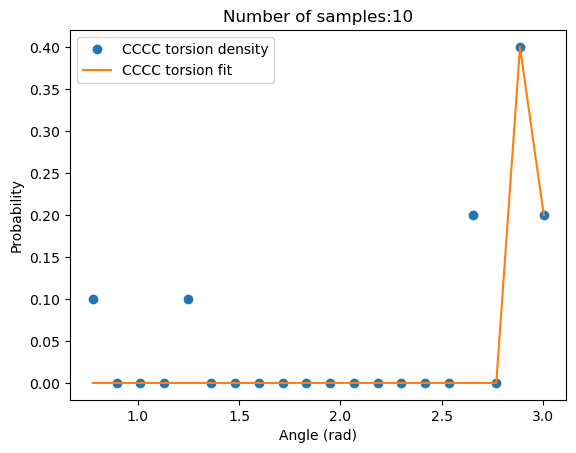

initial guesses: [3.1392503, 2.7436595, 0.59080946]
a: 0.356971667716124, x0: 3.042856129682585, sigma: 0.11712092938294959


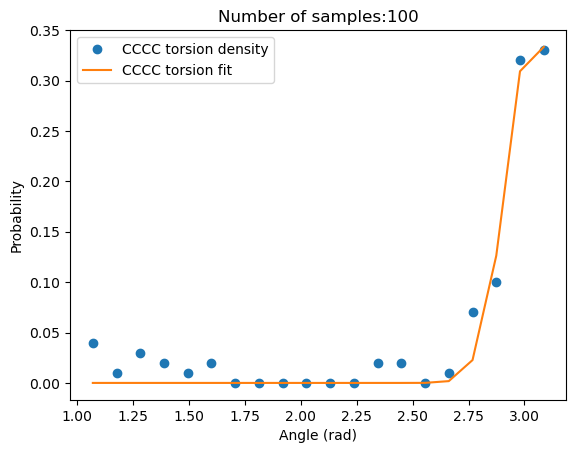

initial guesses: [3.1412263, 2.6318982, 0.69988674]
a: 1.338525141654496, x0: 3.725316685838953, sigma: 0.4128689276721931


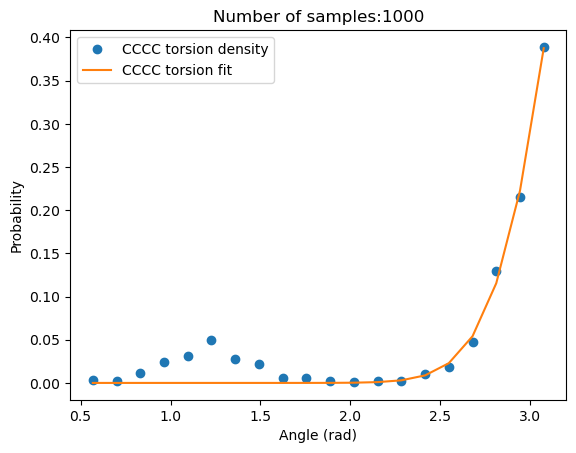

initial guesses: [3.1415725, 2.6064873, 0.7159604]
a: 0.43489504764367715, x0: 3.215819551698842, sigma: 0.2591931517446399


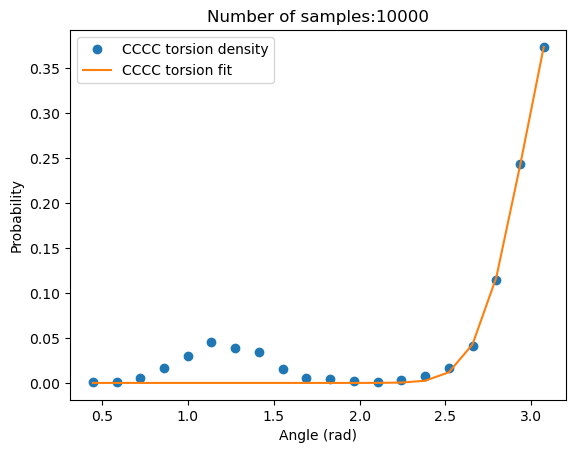

In [39]:
#PART B: DIHEDRAL ANGLE
rands=np.random.randint(10000, size=(10000)) 

samples = [10, 100, 1000, 10000]

CCCC_index = [0, 4, 7, 10]
CCCC_torsion = md.compute_dihedrals(traj, [CCCC_index])
fix = CCCC_torsion.squeeze()
arr = np.abs(fix)

for i in samples:
    rands = np.random.randint(10000, size=(i))
    rand_torsion = arr[rands]

    rand_torsion_density, centers = histogram_bincenters(rand_torsion, 20, min(rand_torsion), max(rand_torsion))
    rand_torsion_fit, rand_torsion_fit_params = fit_gauss(centers, rand_torsion_density, rand_torsion)

    plt.plot(centers, rand_torsion_density, 'o', label="CCCC torsion density")
    plt.plot(centers, rand_torsion_fit, '-', label = "CCCC torsion fit")

    plt.title("Number of samples:" +str(i))
    plt.xlabel("Angle (rad)")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()


Gaussian fit does not work for torsion! This makes sense since torsion angles are better modeled by a bimodal fit. Torsion angles do not happen along a continuous distribution (like bond lengths) but are confined by sterics, resulting in a poor fit.

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

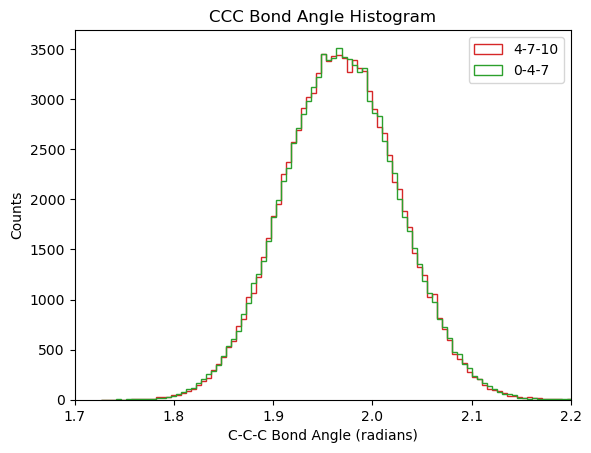

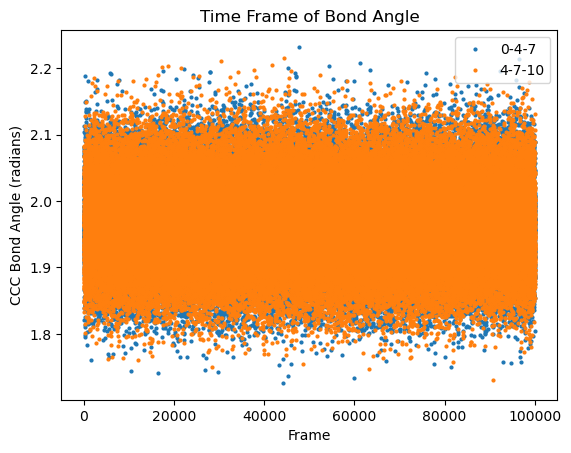

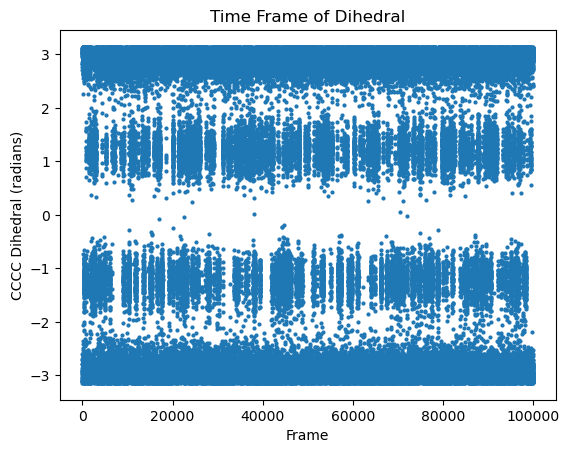

In [40]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2]) #compute angles function, give array of indices and returns array of time series 

#uses linear algebra to solve 
ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1, linewidth=0,marker='x', markersize=0.1)
plt.plot(ang2, linewidth=0,marker='x', markersize=0.1)
plt.hist(ang,bins=100, histtype='step', label=(['0-4-7', '4-7-10']))
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)')
plt.xlim(1.7, 2.2)
plt.ylabel('Counts')
plt.title("CCC Bond Angle Histogram")
plt.show()
plt.clf()

#plotting time frame of bond angle 
plt.plot(ang, "o", markersize=2, label=["0-4-7", "4-7-10"])
plt.xlabel("Frame")
plt.legend(loc="upper right")
plt.ylabel("CCC Bond Angle (radians)")
plt.title("Time Frame of Bond Angle")
plt.show()


#plotting time frame dihedral 
CCCC_atoms = [0, 4, 7, 10]
CCCC_dihedral = md.compute_dihedrals(traj, [CCCC_atoms])

plt.plot(CCCC_dihedral, "o", markersize=2)
plt.xlabel("Frame")
plt.ylabel("CCCC Dihedral (radians)")
plt.title("Time Frame of Dihedral")
plt.show()

#ground state torsion with 180 degree, occassionally get the gauche at + or - 60 

[[ 164.09947]
 [-155.01047]
 [-173.40648]
 ...
 [ 174.37134]
 [ 175.15761]
 [ 176.25145]]


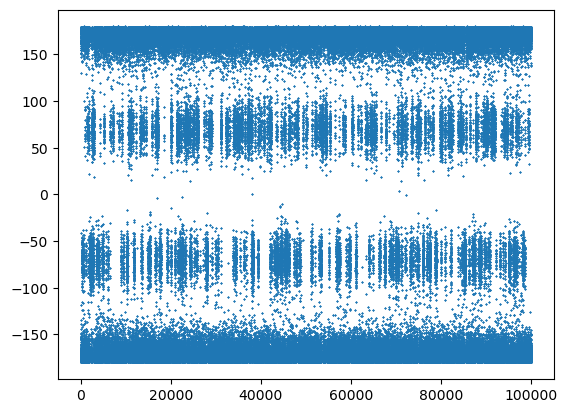

In [41]:
CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
#print(CCCC_torsion)
radtorsion=np.rad2deg(CCCC_torsion)
print(radtorsion)

plt.plot(radtorsion, marker ='x', markersize=1,linewidth=0)

(array([    1,     2,     4, ..., 99989, 99990, 99996]), array([0, 0, 0, ..., 0, 0, 0]))


(0.0, 1000.0)

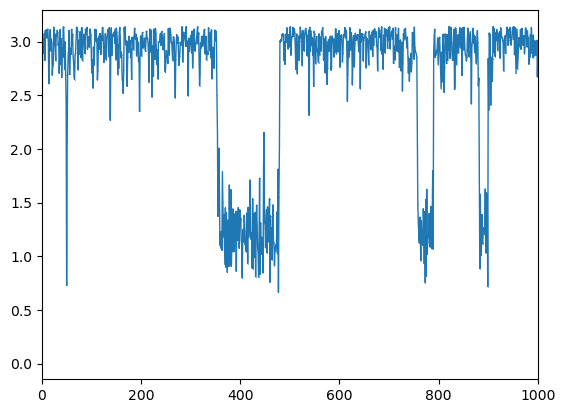

In [42]:
#zoomed in, take values where torsion is less than 0 and add 360 to it 
print(np.where(CCCC_torsion<0))
CCCC_tor_offset = CCCC_torsion

#for i in range(0,len(CCCC_torsion)):
#    if(CCCC_tor_offset[i]<0):
#        CCCC_tor_offset[i]+=360

plt.plot(np.abs(CCCC_tor_offset), marker='x', markersize=0.1, linewidth=1)
plt.xlim([0,1000])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

Number of transitions to gauche: 473
Average residence time: 164.42071881606765


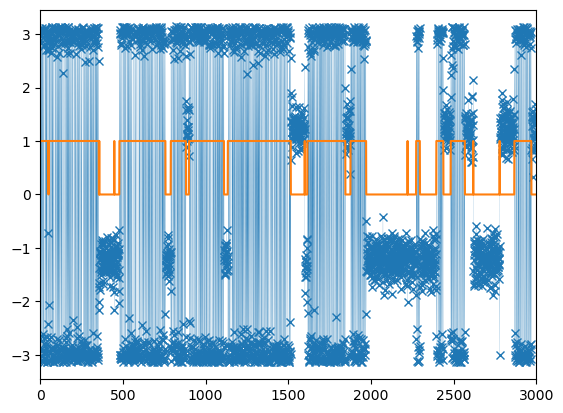

In [43]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html

timeframes = CCCC_torsion[:,0]
zeroes = np.zeros(len(timeframes))
#find where the angle is gauche: 
angles = np.where((CCCC_torsion[:,0]< -2) | (CCCC_torsion[:,0]>2))
zeroes[angles]=1


plt.plot(timeframes ,marker="x", linewidth=0.1)
plt.plot(zeroes)
plt.xlim(0,3000)


gauche = 0
n = 0
time = []

for i in range(1,len(zeroes)):
    if zeroes[i]==1:
        if gauche==0:
            gauche=1
        n+=1
    if zeroes[i]==0:
        gauche=0
        if zeroes[i-1]!=0:
            time.append(n)
            n=0


print("Number of transitions to gauche:", len(time))
print("Average residence time:", np.average(time*100))

#basically defining an array of zeroes and then adding 1 to it if the CCCC angle is in gauche
#then use a for loop to go over that array for every frame and see if there is a 0 or a 1
# for every 1, we use the counter and set gauche = 1, and add 1 frame to n for every instance of 1 in a row 
#then, when the zeroes array goes back to 0, that means the angle is no longer gauche
#so, reset the value of gauche = 0 for the next iteration of the for loop AND add the value of n to the array of all the instances of transitioning to gauche


#probability of it between 0 and -2 and 0 and +2 radians


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

[1.9908391 2.08092   2.0191655 ... 1.9517179 1.9371276 2.001918 ]
r2: 0.004603611169654139
[9.99858113e-05 1.96820257e+00]


/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/CHEM101/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

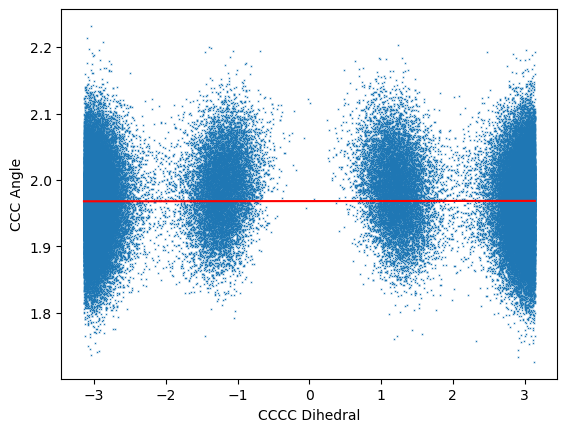

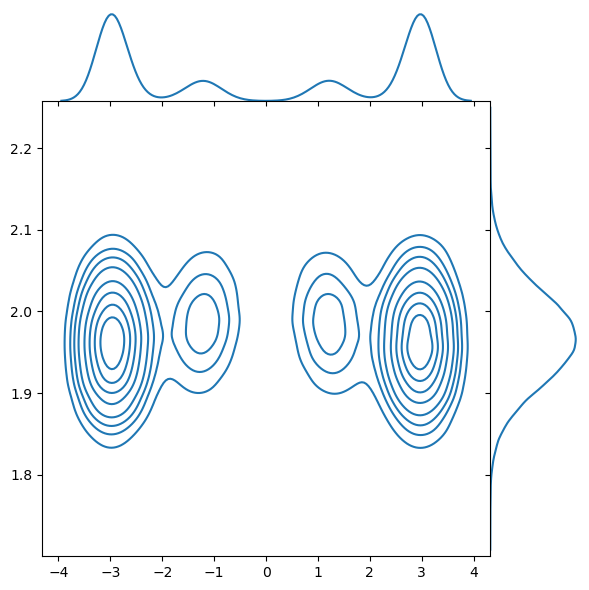

In [44]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?
print(ang1)
CCCC_dihe=CCCC_torsion[:,0]
plt.scatter(CCCC_torsion, ang1, marker='x', s=0.1)
r=np.corrcoef(CCCC_torsion[:,0], ang1)

print("r2:", r[0,1])
line_fit = np.polyfit(CCCC_torsion[:,0], ang1, 1)
print(line_fit)
x=np.linspace(min(CCCC_torsion[:,0]), max(CCCC_torsion[:,0]), 20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r', label = ['best fit line'])
plt.xlabel("CCCC Dihedral")
plt.ylabel("CCC Angle")
#no linear correlation even though there's some sort of relatinoship according to the graph 

##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe, y=ang1, kind='kde', space=0, thresh=0)
#histogram is called marginalization

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

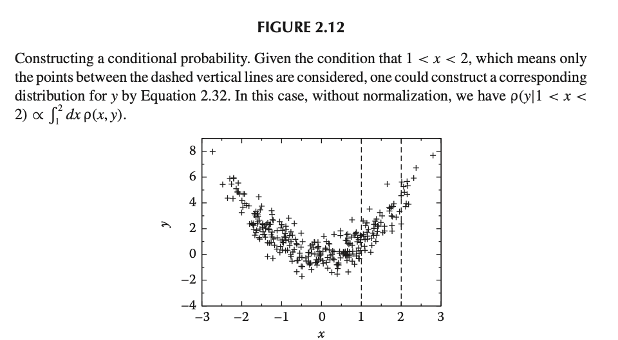

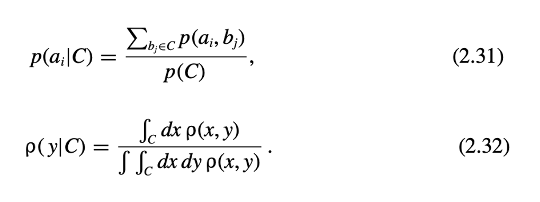

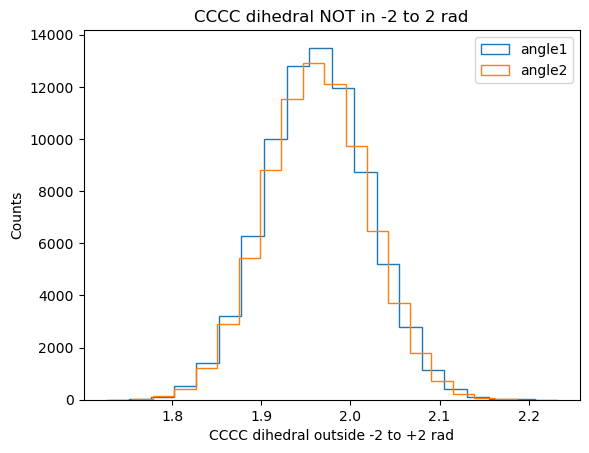

Text(0, 0.5, 'Counts')

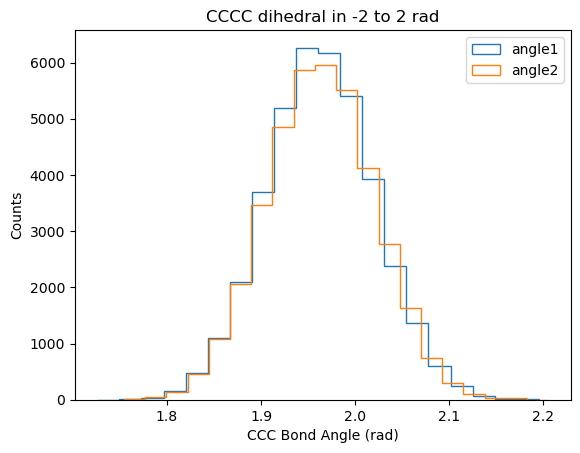

In [45]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html


#use angles from previous problem to find the regions its gauche
plt.hist(ang1[angles], histtype='step', label='angle1', bins=20)
plt.hist(ang2[angles], histtype='step', label='angle2', bins=20)
plt.legend()
plt.xlabel("CCCC dihedral outside -2 to +2 rad")
plt.ylabel("Counts")
plt.title("CCCC dihedral NOT in -2 to 2 rad")
plt.show()
plt.clf()

#regions within -2 and 2 radians (trans)
angles_inregion = np.where((CCCC_torsion[:,0]>-2) & (CCCC_torsion[:,0]>2))
plt.hist(ang1[angles_inregion], histtype="step", label="angle1", bins=20)
plt.hist(ang2[angles_inregion], histtype="step", label="angle2", bins=20)
plt.title("CCCC dihedral in -2 to 2 rad")
plt.legend()
plt.xlabel("CCC Bond Angle (rad)")
plt.ylabel("Counts")

#looking at probability, 

In [46]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#computes in certain number of lags, computes correlation, start at frame 1 w offset of 1, and iteratre l in 2 frames, compute and turn array
    
print(ang1)
print(len(ang1))
print(ang1[1:])
print(ang1[:-1])
#function iterates over all values and calculates r

np.corrcoef(ang1[:-1], ang1[1:])

[1.9908391 2.08092   2.0191655 ... 1.9517179 1.9371276 2.001918 ]
100000
[2.08092   2.0191655 2.0130162 ... 1.9517179 1.9371276 2.001918 ]
[1.9908391 2.08092   2.0191655 ... 1.9140662 1.9517179 1.9371276]


array([[1.        , 0.31406787],
       [0.31406787, 1.        ]])

**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


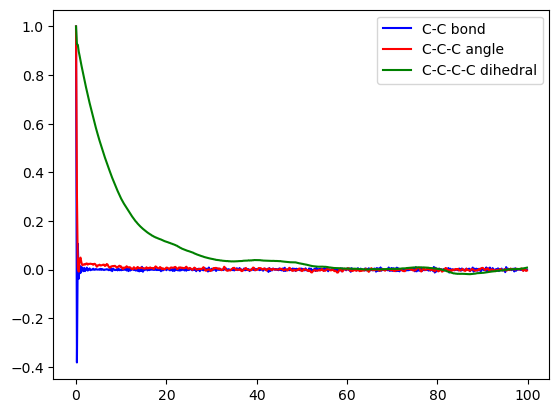

In [47]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

#take out the autoflipping
#decorrelated in a few seconds, very little memory, sampling pass distribution, short trajectory gives you decieving error estimate
#samples independent of each other, 4 statistically indepdent samples of a diherdral 


**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

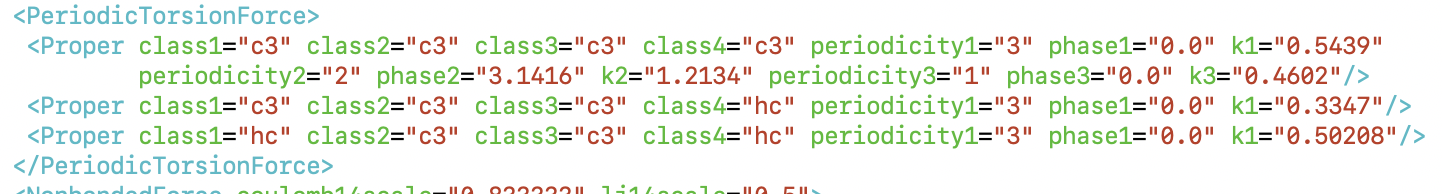

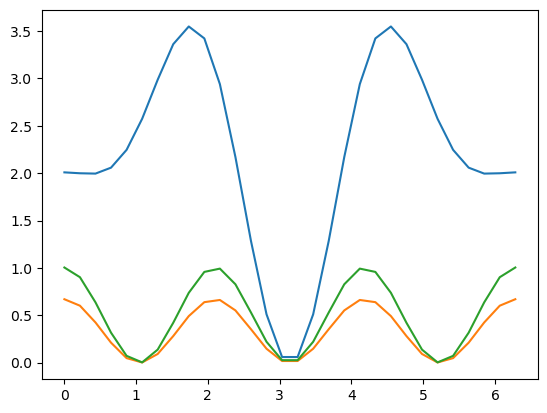

In [48]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

#torsions between different pairs of atoms have different offsets of 60 degrees 
#find example of torsions that are correlated and some that aren't 
#integer periodiciites 

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)


In [49]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [50]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

print("HCCH angles:", HCCH_indices)
#array with all 16 pairings and breaks down which atom it corresponds to (ie one HCCH pairing is atoms 8,7,4,5)

print( "\n HCCH torsions:", HCCH_torsions)
#shows torsion angles for each of the 16 HCCH pairings for each of the frames 

#print(np.shape(HCCH_indices))
#print(np.shape(HCCH_torsions))

HCCH angles: [[8, 7, 4, 5], [8, 7, 4, 6], [9, 7, 4, 5], [9, 7, 4, 6], [6, 4, 0, 1], [6, 4, 0, 2], [6, 4, 0, 3], [5, 4, 0, 1], [5, 4, 0, 2], [5, 4, 0, 3], [13, 10, 7, 8], [12, 10, 7, 8], [11, 10, 7, 8], [13, 10, 7, 9], [12, 10, 7, 9], [11, 10, 7, 9]]

 HCCH torsions: [[ 2.9612806  -1.4696679   1.0312487  ...  2.8337278  -1.1998374
   0.8402317 ]
 [-2.460436   -0.5354856   1.6845958  ... -2.951246   -0.80100024
   1.2723099 ]
 [-3.1375747  -1.2155519   1.0997472  ... -3.1111453  -0.9629886
   1.1502643 ]
 ...
 [ 2.9734128  -1.2695605   0.94092166 ...  0.64063835  2.8008645
  -1.3738909 ]
 [ 3.0993397  -1.2031382   1.0173222  ...  0.7935394   2.824557
  -1.3844792 ]
 [ 3.1370742  -1.0708798   1.1444674  ...  1.1214144  -3.0305912
  -0.96201485]]


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

r2: 0.6308951289012453


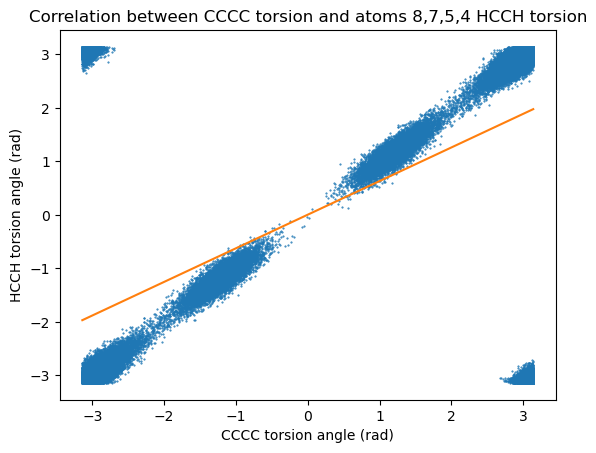

In [51]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]
plt.plot(CCCC_torsion.squeeze(), HCCH_torsions[:,0], 'o', markersize=0.5)
plt.xlabel("CCCC torsion angle (rad)")
plt.ylabel("HCCH torsion angle (rad)")
plt.title("Correlation between CCCC torsion and atoms 8,7,5,4 HCCH torsion")
r = np.corrcoef(CCCC_torsion.squeeze(), HCCH_torsions[:,0])
print("r2:",r[0,1])
bestfit = np.polyfit(CCCC_torsion.squeeze(), HCCH_torsions[:,0], 1)
x = np.linspace(min(CCCC_torsion.squeeze()), max(CCCC_torsion.squeeze()), 20)
y = bestfit[1]+x*bestfit[0]
plt.plot(x, y, label="best fit")


#defined the indices above, and the torsion of atoms 8, 7, 4, 5 is the first item in the array which is index 0


Explanation: Highly correlated torsion angles are those that are constrained because of being confined by sterics/bonds. For example, the hydrogen/carbon angle of C2 and C3 must be related to the other central carbon/hydrogen atom. Atoms 8, 7, 5, 4 specifically correspond to the C2-C3 bond and two hydrogens attached to each of them. Looking along the C2C3 bond and drawing a Newman projection, it's clear that the rotation of the hydrogens are confined by the steric interactions between the methyl groups attached to both C2 and C3. As the two angles have a very high correlation (r^2 of 0.64), it's clear that in some cases, the C2H and C3H pair might have the same angle. The corners with (-3,-3) + (-3,3) + (3,-3) correspond to the trans conformation (as 3 radians is ~180 degrees). Depending on which atom is labeled as the "front atom" of the Newman projection, the trans angle could be either +180 or -180. Also, the lack of data at (0,0) also makes sense, since a torsion angle of 0 means these atoms are experiencing intense steric interactions which is unfavorable/not likely to happen (eclipsed conformation). 

r2: 0.02291020202572603


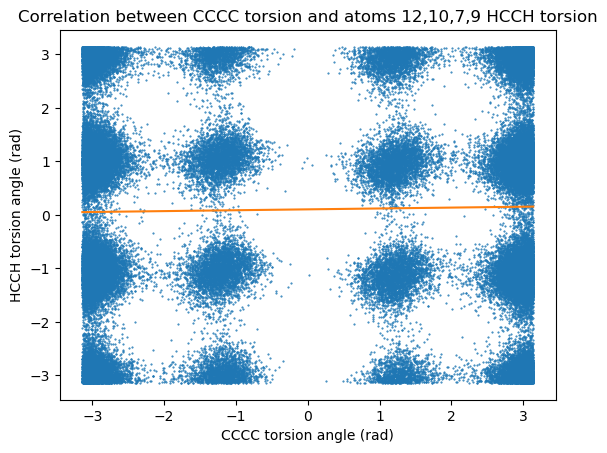

In [52]:
#plotting UNcorrelated torsions


#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]
#corresponds to HCCH index 14 as defined above 
plt.plot(CCCC_torsion.squeeze(), HCCH_torsions[:,14], 'o', markersize=0.5)
plt.xlabel("CCCC torsion angle (rad)")
plt.ylabel("HCCH torsion angle (rad)")
plt.title("Correlation between CCCC torsion and atoms 12,10,7,9 HCCH torsion")
r = np.corrcoef(CCCC_torsion.squeeze(), HCCH_torsions[:,14])
print("r2:",r[0,1])
bestfit = np.polyfit(CCCC_torsion.squeeze(), HCCH_torsions[:,14], 1)
x = np.linspace(min(CCCC_torsion.squeeze()), max(CCCC_torsion.squeeze()), 20)
y = bestfit[1]+x*bestfit[0]
plt.plot(x, y, label="best fit")

Explanation: The hydrogens on the two terminal carbons are not confined as they are free to rotate, leading to less correlated torsions. The HCCH torsion corresponding to atoms 12, 7, 10, 9 is looking at a C3H and a C4H pair. Since the C4 is the terminal carbon in butane, the three hydrogens are free to rotate and are not bound by steric interactions as much as the hydrogens attached to C2 and C3. As such, we expect to see uncorrelated angles here, which is what is observed. The r^2 value is 0.02 (suggesting no correlation). The scatterplot also shows that for every possible CCCC torsion angle, the HCCH torsion angle can also have any value within standard conformations. 

The main groupings we see are again nothing around (0,0), which makes sense as an eclipsed conformation is unfavorable. The groups around + or - 1 correspond to the gauche conformation (1 radian is about 60 degrees) or in the trans conformation with + or - 3 rad (180 degrees). The groupings around +3 and -3 seem to have a slightly higher population of frames, which makes sense, given that placing the CH2CH3 bulkier group in the trans position is more favorable. 

**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

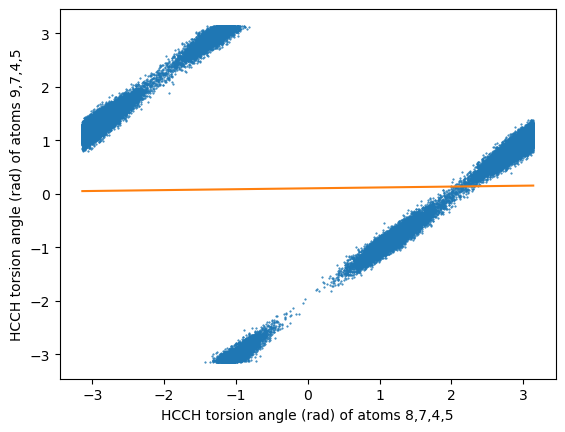

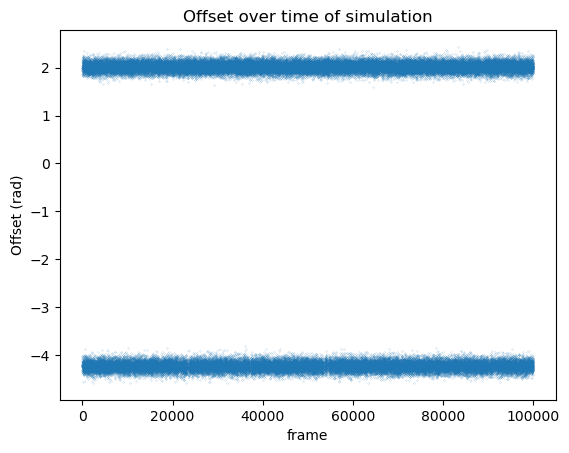

<Figure size 640x480 with 0 Axes>

In [53]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#4,5,7,9 corresponds w index 2 

plt.plot(HCCH_torsions[:,0], HCCH_torsions[:,2], 'o', markersize=0.5)
plt.xlabel("HCCH torsion angle (rad) of atoms 8,7,4,5")
plt.ylabel("HCCH torsion angle (rad) of atoms 9,7,4,5")
#plt.title("Correlation between CCCC torsion and atoms 4,5,7,9 HCCH torsion")
plt.plot(x, y, label="best fit")
plt.show()
plt.clf()

#calculating offset 
#find the difference between the CCCC torsion and the HCCH torsion
difference = HCCH_torsions[:,0]-HCCH_torsions[:,2]
plt.plot(difference, 'o', markersize=0.1)
plt.xlabel("frame")
plt.ylabel("Offset (rad)")
plt.title("Offset over time of simulation")
plt.show()
plt.clf()

Since this is comparing the torsion angle difference between two hydrogens attached to C3, I'd expect them to have an offset given that the two H atoms cannot occupy the same space and the steric interaction of the molecule must be minimized. The offset over the course of the simulation is shown to be either +2 radians (120 degrees) and -4 rad (~ -240 degrees). Since this is looking at the offset, a difference of 120 shows the trans conformation offset (trans is if the angle is 180 degrees, but since the H is offset by 60 it would be 120). The -240 degrees can be seen as the same explanation from a different angle convention. 

In [ ]:
####WEEK 1 STOP HERE######

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

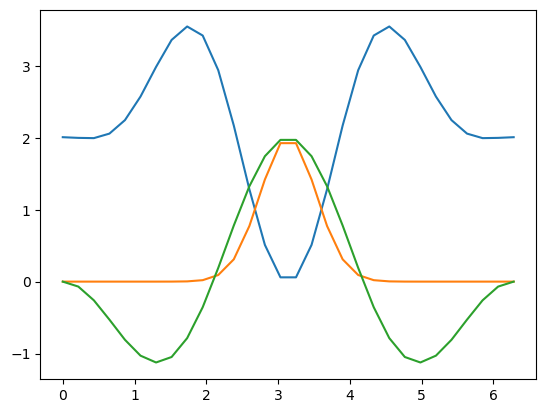

In [54]:
###SOLUTION#####

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

plt.plot(rad_ang,CCCC_e)

#We want to mimic a gaussian potential that adds potential energy when the CCCC diehdral = pi = 180 degrees
#We can think of this as approximating a guassian center at theta= 180
###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#Here is what we want our dihedral correction to look like:

gauss_cor = gauss(rad_ang, 2, np.pi, np.pi/8)
plt.plot(rad_ang,gauss_cor)

#Here I come up with a correction that should have the desired effect:

def TorsionCorrection(angle):
 e1=calc_torsion_energy(angle,-1,1,0)
 e2=calc_torsion_energy(angle,1,2,0)
 #e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2

torsion_cor=TorsionCorrection(rad_ang)

plt.plot(rad_ang,torsion_cor)



***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

*Added new terms to the XML file. Used trial and error to find new torsion terms that even out the potentials!*

In [55]:
#RUN NEW MD SIMULATION HERE#
workdir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/'
datadir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/data/'
outdir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.cor1.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/data/butane.pdb
/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Exercise 0/data/butane.gaff2.cor1.xml


In [56]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 8.536491676355517 kJ/mol
Potential energy after minimization is 8.03366982909051 kJ/mol


In [57]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,37.32740590173919,472.38583738888843
2000,32.62876112575992,266.8711076448988


In [58]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,39.65975520087174,312.81236377293834,0
500000,999.9999999901769,36.19392038243345,259.1560521590219,1.6e+04
750000,1499.9999999783536,41.730214952240146,219.09723620398674,1.62e+04
1000000,1999.9999999665301,41.82289647743528,241.3228701063973,1.6e+04
1250000,2499.9999999547067,51.48680522196611,263.76749817772475,1.65e+04
1500000,2999.9999999428833,46.394837440470425,286.1102322999903,1.68e+04
1750000,3499.99999993106,38.60930385287253,212.53055608064955,1.7e+04
2000000,3999.9999999192364,45.866107419356084,282.30161359641806,1.7e+04
2250000,4499.9999999992715,42.06711238906843,363.17056123113764,1.71e+04
2500000,5000.000000101135,32.55792087333475,243.71166442604456,1.73e+04
2750000,5500.000000202998,45.462506437169424,263.1798787696779,1.72e+04
3000000,6000.000000304862,45.233632097121394,216.284683879086,1.73e+04
3250000,6500.000000406725,50.42648705095

In [59]:
updated_traj = md.load(os.path.join(workdir, "butane_sim.dcd"), top=PDB_file_name)
CCCC_index = [10,7,4,0]
updated_CCCC_torsion = md.compute_dihedrals(updated_traj, [CCCC_index])

Text(0.5, 1.0, 'Distribution of CCCC torsion angles for updated and old forcefield')

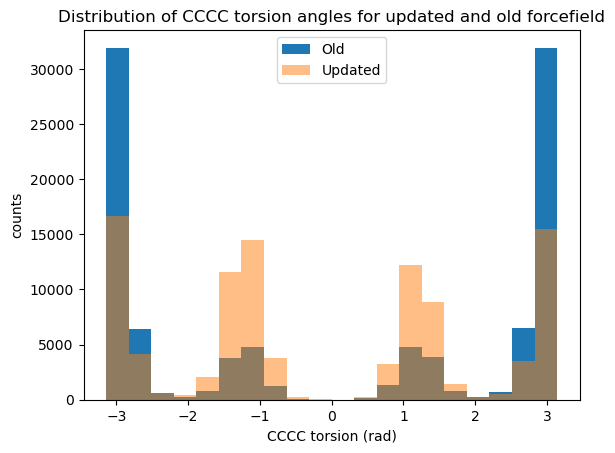

In [60]:
#Compare New Dihedral Distribution HERE)
plt.hist(CCCC_torsion.squeeze(), label = "Old", bins = 20)
plt.hist(updated_CCCC_torsion.squeeze(), label="Updated", bins=20, alpha=0.5)
plt.legend(loc="upper center")
plt.xlabel("CCCC torsion (rad)")
plt.ylabel("counts")
plt.title("Distribution of CCCC torsion angles for updated and old forcefield")

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


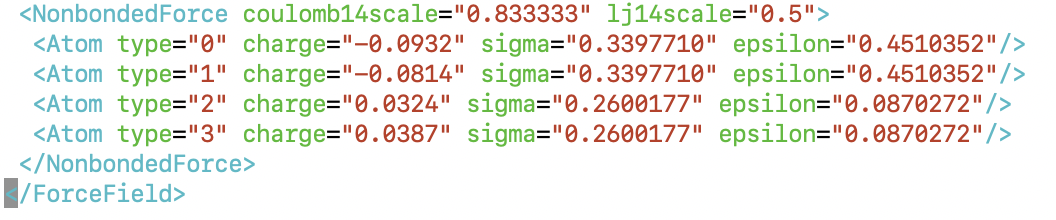




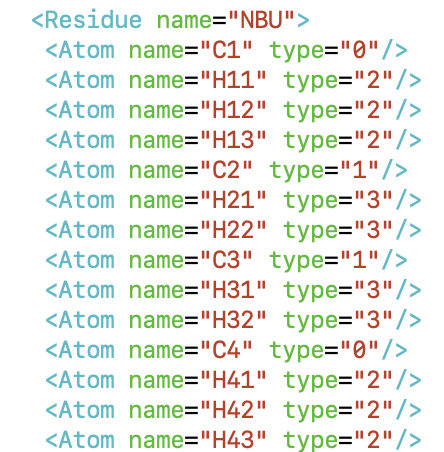

In [ ]:
#Plot LJ and Couloumb Potentionals Here

Text(0, 0.5, 'potential energy')

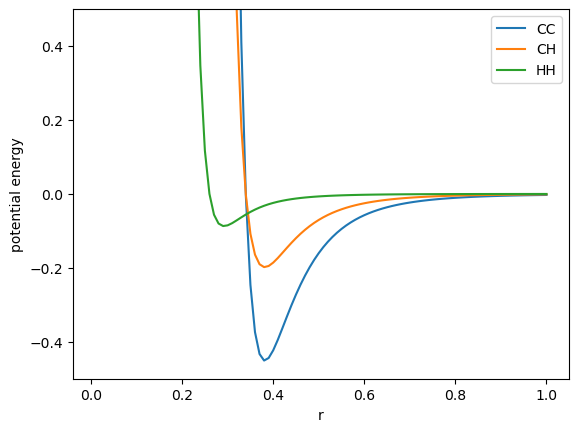

In [61]:
#Lennard Jones potential

#use values written in the XML file
#carbon atoms
sig_c = 0.3397710
sig_h = 0.2600177

ep_c = 0.4510352
ep_h = 0.0870272

#c1 are the terminal carbons, c2 are in the middle
#h1 are terminal and h2 are in the middle
q_c1 = -0.0932
q_c2 = -0.0814
q_h1 = 0.0324
q_h2 = 0.0387

#to find LJ potentials of each of the pairings (CC, CH, HH) can average values across the molecule
#define functions to average and one to calculate LJ
#remember to use geometric avg for ep and artihmetic for sigma

def lennard(ep, sigma, r):
    return (4*ep*((sigma/r)**12 - (sigma/r)**6))

def geo_avg(ep1, ep2):
    return (ep1*ep2)**0.5

def arith_avg(sig1, sig2):
    return (sig1+sig2)/2

#to plot a function, use linspace to get many values of r
r = np.linspace(0.01,1,100)

#calculate for each:
#CC
epCC = geo_avg(ep_c, ep_c)
sigCC = arith_avg(sig_c, sig_c)
lj_CC = lennard(epCC, sigCC, r)

#CH
epCH = geo_avg(ep_c, ep_h)
sigCH = arith_avg(sig_c, sig_c)
lj_CH = lennard(epCH, sigCH, r)

#HH
epHH = geo_avg(ep_h, ep_h)
sigHH = arith_avg(sig_h, sig_h)
lj_HH = lennard(epHH, sigHH, r)

plt.plot(r, lj_CC, label="CC")
plt.plot(r, lj_CH, label="CH")
plt.plot(r, lj_HH, label="HH")
plt.legend()
plt.xlabel("r")
plt.ylim(-0.5, 0.5)
plt.ylabel("potential energy")

Text(0, 0.5, 'coulombic potential')

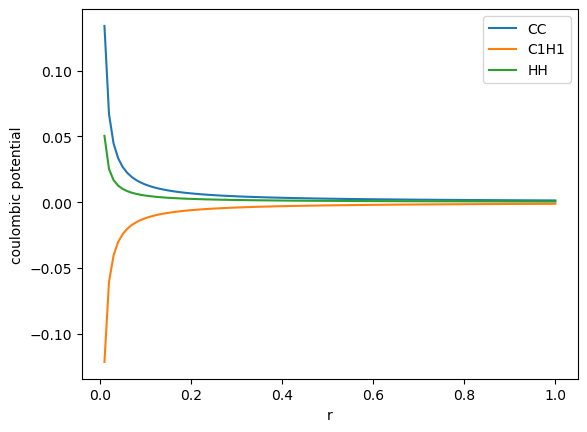

In [62]:
#Calculate coulombs potential

def coulomb(q1, q2, r, ep):
    return (q1*q2)/(4*np.pi*ep*r)

#calculate for each 
cc_coul = coulomb(q_c1,q_c2, r, epCC)
ch_coul = coulomb(q_c1,q_h1, r, epCH)
test = coulomb(q_c1,q_h2, r, epCH)
hh_coul = coulomb(q_h1,q_h2, r, epCH)

plt.plot(r,cc_coul, label="CC")
plt.plot(r,ch_coul, label="C1H1")
#since both C atoms and both H atoms have the same sigma/epsilon values, the Fc of C1H1 is the same as C1H2 and C2H1
plt.plot(r,hh_coul, label="HH")
plt.legend()
plt.xlabel("r")
plt.ylabel("coulombic potential")